# DNA Methylation (JHU-USC beta values)

The goal of this notebook is to introduce you to the DNA methylation BigQuery table.

This table contains all available TCGA Level-3 DNA methylation data produced by the JHU-USC methylation pipeline using the Illumina Infinium Human Methylation 27k and 450k platforms, as of July 2016.  The most recent archives (*eg* ``jhu-usc.edu_HNSC.HumanMethylation450.Level_3.18.8.0``) for each of the 33 tumor types were downloaded from the DCC, and data extracted from all files matching the pattern ``jhu-usc.edu_%.HumanMethylation%.lvl-3.%.txt``. Each of these text files has five columns.  The first two columns contain the CpG probe id and the methylation beta value.  The additional columns contain annotation information (gene symbol(s), and chromosome and genomic coordinate for the CpG probe).  Only the CpG probe id and the beta value were extracted during ETL and stored in this BigQuery table, along with the aliquot ID (which can be found both in the text filename, and in the SDRF file in the mage-tab archive).

**WARNING**: This BigQuery table contains almost **4 billion** rows of data and is over 400 GB in size.  When experimenting with new queries, be sure to put a "LIMIT" on the results to avoid accidentally launching a query that might either take a very very long time or produce a very large results table! 

**NOTE**: For convenience, individual per-chromosome tables are also available, so if your queries are specific to a single chromosome, your queries will be faster and cheaper if you use the appropriate single-chromosome table.

In order to work with BigQuery, you need to import the python bigquery module (`gcp.bigquery`) and you need to know the name(s) of the table(s) you are going to be working with:

In [1]:
import gcp.bigquery as bq
meth_BQtable = bq.Table('isb-cgc:tcga_201607_beta.DNA_Methylation_betas')

From now on, we will refer to this table using this variable ($meth_BQtable), but we could just as well explicitly give the table name each time.

Let's start by taking a look at the table schema:

In [2]:
%bigquery schema --table $meth_BQtable

Let's count up the number of unique patients, samples and aliquots mentioned in this table.  Using the same approach, we can count up the number of unique CpG probes.  We will do this by defining a very simple parameterized query.  (Note that when using a variable for the table name in the FROM clause, you should not also use the square brackets that you usually would if you were specifying the table name as a string.)

In [3]:
%%sql --module count_unique

DEFINE QUERY q1
SELECT COUNT (DISTINCT $f, 500000) AS n
FROM $t

In [4]:
fieldList = ['ParticipantBarcode', 'SampleBarcode', 'AliquotBarcode', 'Probe_Id']
for aField in fieldList:
  field = meth_BQtable.schema[aField]
  rdf = bq.Query(count_unique.q1,t=meth_BQtable,f=field).results().to_dataframe()
  print " There are %6d unique values in the field %s. " % ( rdf.iloc[0]['n'], aField)

 There are  10998 unique values in the field ParticipantBarcode. 
 There are  12232 unique values in the field SampleBarcode. 
 There are  12279 unique values in the field AliquotBarcode. 
 There are 397665 unique values in the field Probe_Id. 


As mentioned above, two different platforms were used to measure DNA methylation.  The annotations from Illumina are also available in a BigQuery table:

In [5]:
methAnnot = bq.Table('isb-cgc:platform_reference.methylation_annotation')

In [6]:
%bigquery schema --table $methAnnot

Given the coordinates for a gene of interest, we can find the associated methylation probes.

In [7]:
%%sql --module getGeneProbes

SELECT
  IlmnID, Methyl27_Loci, CHR, MAPINFO
FROM
  $t
WHERE
  ( CHR=$geneChr
    AND ( MAPINFO>$geneStart AND MAPINFO<$geneStop ) )
ORDER BY
  Methyl27_Loci DESC, 
  MAPINFO ASC

In [8]:
# MLH1 gene coordinates (+/- 2500 bp)
geneChr = "3"
geneStart = 37034841 - 2500
geneStop  = 37092337 + 2500
mlh1Probes = bq.Query(getGeneProbes,t=methAnnot,geneChr=geneChr,geneStart=geneStart,geneStop=geneStop).results()

There are a total of 50 methlyation probes in and near the MLH1 gene, although only 6 of them are on both the 27k and the 450k versions of the platform.

In [9]:
mlh1Probes

IlmnID,Methyl27_Loci,CHR,MAPINFO
cg24607398,TRUE,3,37033625
cg10990993,TRUE,3,37033632
cg18320188,TRUE,3,37033980
cg02279071,TRUE,3,37034154
cg00893636,TRUE,3,37034840
cg13846866,TRUE,3,37035399
cg02103401,FALSE,3,37033373
cg04726821,FALSE,3,37033791
cg11291081,FALSE,3,37033894
cg05670953,FALSE,3,37033903


We can now use this list of CpG probes as a filter on the data table to extract all of the methylation data across all tumor types for MLH1:

In [10]:
%%sql --module getMLH1methStats

SELECT 
  cpg.IlmnID AS Probe_Id,
  cpg.Methyl27_Loci AS Methyl27_Loci,
  cpg.CHR AS Chr,
  cpg.MAPINFO AS Position,
  data.beta_stdev AS beta_stdev,
  data.beta_mean AS beta_mean,
  data.beta_min AS beta_min,
  data.beta_max AS beta_max
FROM (
  SELECT *
  FROM $mlh1Probes 
) AS cpg
JOIN (
  SELECT 
    Probe_Id,
    STDDEV(beta_value) beta_stdev,
    AVG(beta_value) beta_mean,
    MIN(beta_value) beta_min,
    MAX(beta_value) beta_max
    FROM $meth_BQtable
    WHERE ( SampleTypeLetterCode=$sampleType )
    GROUP BY Probe_Id
) AS data
ON 
  cpg.IlmnID = data.Probe_Id
ORDER BY
  Position ASC

In [11]:
qTP = bq.Query(getMLH1methStats,mlh1Probes=mlh1Probes,meth_BQtable=meth_BQtable,sampleType="TP")
rTP = qTP.results().to_dataframe()
rTP.describe()

,Position,beta_stdev,beta_mean,beta_min,beta_max
count,4.700000e+01,47.000000,47.000000,47.00000,47.00000
mean,3.703835e+07,0.116978,0.162811,0.02617,0.92766
std,1.290713e+04,0.054359,0.252920,0.04897,0.04478
min,3.703337e+07,0.042250,0.021628,0.00000,0.76000
25%,3.703416e+07,0.087674,0.039952,0.01000,0.91000
50%,3.703482e+07,0.097174,0.058558,0.01000,0.94000
75%,3.703521e+07,0.127576,0.138661,0.02000,0.96000
max,3.709219e+07,0.265561,0.937656,0.20000,1.00000


In [12]:
qNT = bq.Query(getMLH1methStats,mlh1Probes=mlh1Probes,meth_BQtable=meth_BQtable,sampleType="NT")
rNT = qNT.results().to_dataframe()
rNT.describe()

,Position,beta_stdev,beta_mean,beta_min,beta_max
count,4.700000e+01,47.000000,47.000000,47.000000,47.000000
mean,3.703835e+07,0.041599,0.141202,0.080426,0.406170
std,1.290713e+04,0.049926,0.257221,0.204939,0.305048
min,3.703337e+07,0.004829,0.011083,0.000000,0.060000
25%,3.703416e+07,0.012086,0.022814,0.010000,0.180000
50%,3.703482e+07,0.018195,0.038090,0.010000,0.230000
75%,3.703521e+07,0.031974,0.099666,0.030000,0.665000
max,3.709219e+07,0.178273,0.947594,0.860000,0.970000


In [13]:
import numpy as np
import matplotlib.pyplot as plt

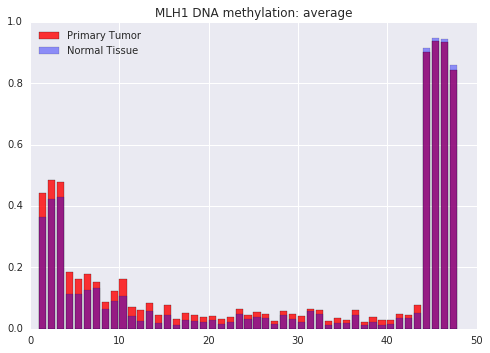

In [14]:
bins=range(1,len(rTP)+1)
#print bins
plt.bar(bins,rTP['beta_mean'],color='red',alpha=0.8,label='Primary Tumor');
plt.bar(bins,rNT['beta_mean'],color='blue',alpha=0.4,label='Normal Tissue');
plt.legend(loc='upper left');
plt.title('MLH1 DNA methylation: average');

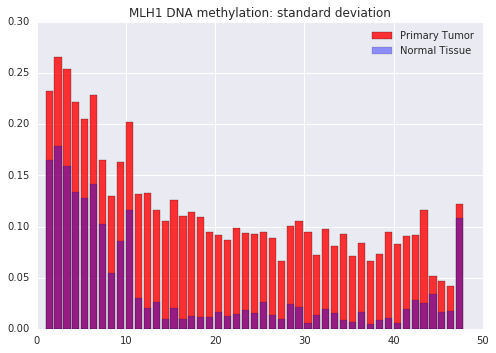

In [15]:
plt.bar(bins,rTP['beta_stdev'],color='red',alpha=0.8,label='Primary Tumor');
plt.bar(bins,rNT['beta_stdev'],color='blue',alpha=0.4,label='Normal Tissue');
plt.legend(loc='upper right');
plt.title('MLH1 DNA methylation: standard deviation');

From the figures above, we can see that, with the exception of the CpG probes near the 3' end of MLH1, the primary tumor samples have a slightly higher average methylation, with significantly greater variability.